# Jun 14th, 2022 (ttest + ovp score new)

**Motivation**: This allows to prune + calculate ovp scores in a much more principled way <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.network import *
from analysis.group import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Prepare

In [2]:
mice = Mice(128)

_BOLD = 'BOLD'
_CAS = r'Ca$^{2\!\!+}$' + ' (slow)'
_CAF = r'Ca$^{2\!\!+}$' + ' (fast)'
mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {_BOLD: rocket(0.6), _CAS: mako(0.6), _CAF: to_rgb('C8')} # mako(0.3)}

In [3]:
task = 'rest'
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

num_k, p = 7, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [4]:
gr_ca.avg()

In [5]:
gr_ca.pi_symmetry_score()

(
    {
        1: 0.989,
        2: 0.99,
        3: 0.995,
        4: 0.994,
        5: 0.988,
        6: 0.991,
        7: 0.998,
        -1: 0.992
    },
    {
        1: 0.987,
        2: 1.0,
        3: 0.974,
        4: 0.987,
        5: 0.987,
        6: 0.987,
        7: 1.0,
        -1: 0.989
    }
)

In [6]:
pi_prune = gr_ca.prune()
pi = avg(pi_prune)

In [7]:
gr_ca.pi_symmetry_score(pi)

(
    {
        1: 0.984,
        2: 0.982,
        3: 0.991,
        4: 0.988,
        5: 0.996,
        6: 0.975,
        7: 0.98,
        -1: 0.985
    },
    {
        1: 0.987,
        2: 1.0,
        3: 0.974,
        4: 0.987,
        5: 1.0,
        6: 0.987,
        7: 0.987,
        -1: 0.989
    }
)

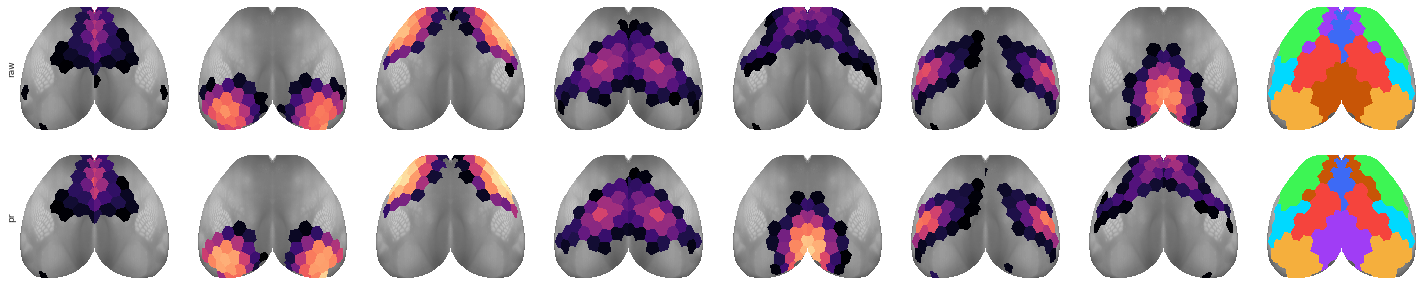

In [8]:
_ = gr_ca.show({'raw': gr_ca.pi, 'pr': pi}, vmin=0.1, vmax=1.0, figsize=(25, 5))

In [9]:
pi_prune.shape

(10, 3, 4, 300, 7, 152)

In [10]:
%%time

boot = bootstrap(
    x=pi_prune,
    n_resamples=int(1e3),
    statistic=lambda a: avg(a, 2, 1),
    skip=['d0'],
    dims=4,
)
se = bn.nanstd(boot, 0, ddof=1)
boot.shape, se.shape

CPU times: user 2min 15s, sys: 1min 24s, total: 3min 40s
Wall time: 3min 40s


((1000, 7, 152), (7, 152))

In [92]:
reject, pvals = gr_ca.ttest(se, pi, mu=0.05)
counts = collections.Counter(reject.sum(0))
counts, 1 - counts.get(1) / sum(counts.values())

(Counter({2.0: 45, 1.0: 30, 3.0: 55, 4.0: 15, 5.0: 7}), 0.8026315789473684)

In [93]:
reject, pvals = gr_ca.ttest(se, pi, mu=0.1)
counts = collections.Counter(reject.sum(0))
counts, 1 - counts.get(1) / sum(counts.values())

(Counter({2.0: 63, 1.0: 51, 3.0: 34, 4.0: 3, 5.0: 1}), 0.6644736842105263)

In [94]:
reject, pvals = gr_ca.ttest(se, pi, mu=0.15)
counts = collections.Counter(reject.sum(0))
counts, 1 - counts.get(1) / sum(counts.values())

(Counter({2.0: 59, 1.0: 74, 3.0: 18, 4.0: 1}), 0.513157894736842)

In [95]:
reject, pvals = gr_ca.ttest(se, pi, mu=0.2)
counts = collections.Counter(reject.sum(0))
counts, 1 - counts.get(1) / sum(counts.values())

(Counter({2.0: 51, 1.0: 97, 3.0: 4}), 0.36184210526315785)

In [108]:
reject, pvals = gr_ca.ttest(se, pi, mu=0.15)
counts = collections.Counter(reject.sum(0))
counts, 1 - counts.get(1) / sum(counts.values())

(Counter({2.0: 59, 1.0: 74, 3.0: 18, 4.0: 1}), 0.513157894736842)

In [109]:
disjoint = reject.sum(0) == 1
mixed = reject.sum(0) > 1

In [110]:
mixed.sum() / (mixed.sum() + disjoint.sum())

0.5131578947368421

In [111]:
community_sizes = reject.sum(1)
community_sizes

array([28., 41., 41., 43., 34., 31., 32.])

In [117]:
members = reject == 1
np.round((members * mixed).sum(1) / members.sum(1) * 100)

array([ 89.,  37.,  44.,  93.,  59.,  84., 100.])

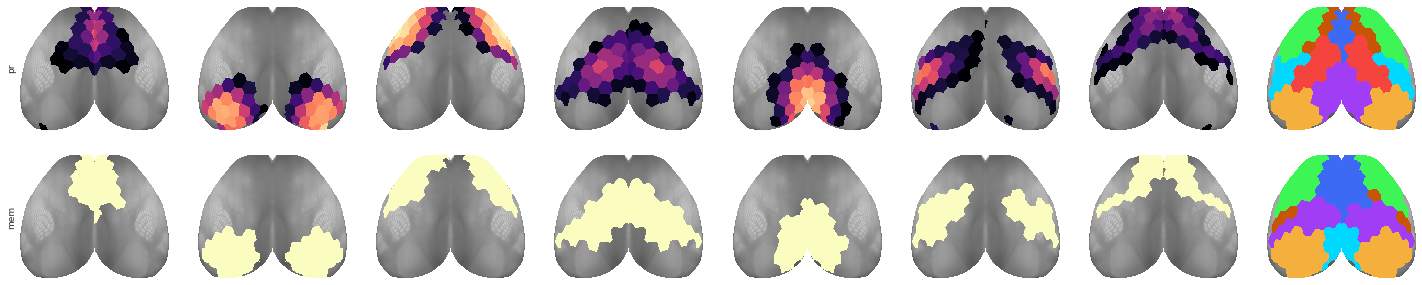

In [114]:
_ = gr_ca.show({'pr': pi, 'mem': members.astype(float)}, vmin=0.1, vmax=1.0, figsize=(25, 5))

In [145]:
members = np.zeros(pi.shape)

for i, mu in enumerate([0.5, 0.3, 0.2, 0.1], start=1):
    reject, pvals = gr_ca.ttest(se, pi, mu=mu)
    members[reject == 1] += i

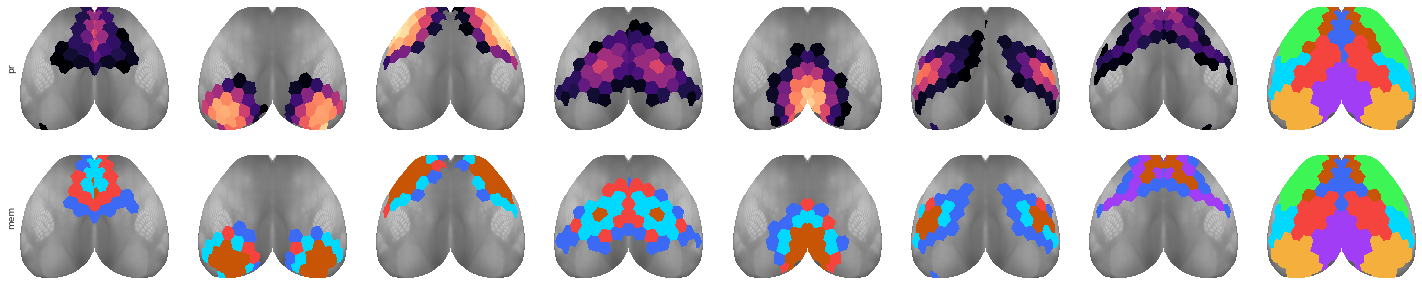

In [146]:
_ = gr_ca.show({'pr': pi, 'mem': members.astype(float)}, vmin=0.1, vmax=1.0, figsize=(25, 5))

In [147]:
members /= np.nanmax(members)

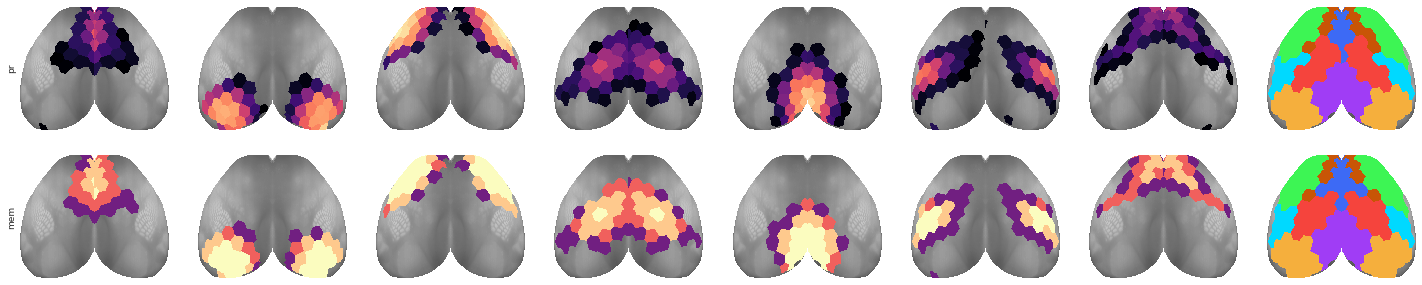

In [148]:
_ = gr_ca.show({'pr': pi, 'mem': members.astype(float)}, vmin=0.1, vmax=1.0, figsize=(25, 5))

In [4]:
%%time

boot = bootstrap(
    x=gr_ca.run_pi,
    n_resamples=int(1e3),
    statistic=lambda a: avg(a, 2, 2),
    skip=['d0'],
    dims=4,
)
se = bn.nanstd(boot, 0, ddof=1)
boot.shape, se.shape

CPU times: user 2min 26s, sys: 1min 24s, total: 3min 50s
Wall time: 3min 50s


((1000, 10, 7, 152), (10, 7, 152))

<matplotlib.lines.Line2D object at 0x7f46c5c01a30>

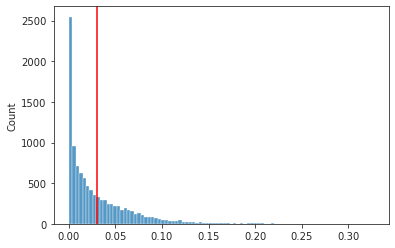

In [5]:
sns.histplot(se.ravel())
plt.axvline(np.nanmean(se), color='r')

In [6]:
pi = avg(gr_ca.run_pi, 2, 1)
pi.shape

(10, 7, 152)

<AxesSubplot:ylabel='Count'>

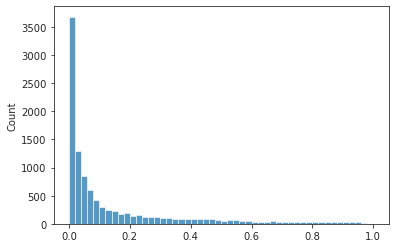

In [7]:
sns.histplot(pi.ravel(), bins=np.linspace(0, 1, 51))

In [11]:
alpha = 0.05
mu = 0.003

reject, pvals = gr_ca.ttest(
    se=se,
    mu=mu,
    alpha=alpha,
    multi='fdr_bh', # 'fdr_tsbh'
)

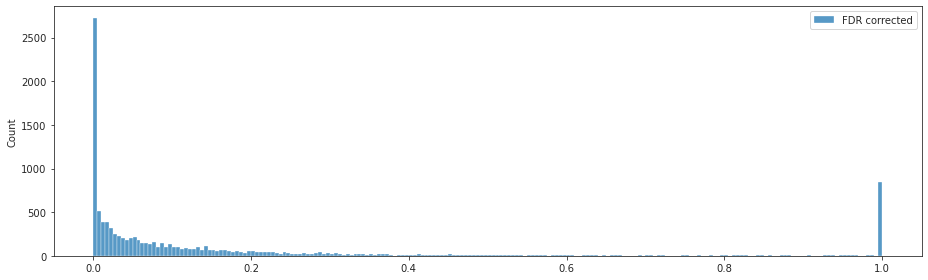

In [12]:
fig, ax = create_figure(1, 1, figsize=(13, 4))
sns.histplot(pvals.ravel(), bins=np.linspace(0, 1, 201), color='C0', label='FDR corrected')
plt.legend()
plt.show()

In [13]:
(reject == 0).sum() / ((reject == 0).sum() + (reject == 1).sum())

0.5131578947368421

In [16]:
def prune(
        self,
        pi: np.ndarray = None,
        n_resamples: int = int(1e3),
        thres: float = 0.003,
        alpha: float = 0.05, ):
    pi = pi if pi is not None else self.run_pi
    f = [
        'se',
        'indiv-pi',
        f"{n_resamples:1.1e}",
    ]
    fname = '_'.join(f)
    file = pjoin(self.path, f"{fname}.npy")
    if os.path.isfile(file):
        se_anim = np.load(file, mmap_mode='r')
        print(np.nanmean(se))
    else:
        b_anim = bootstrap(
            x=pi,
            n_resamples=n_resamples,
            statistic=lambda a: avg(a, 2, 2),
            skip=['d0'],
            dims=4,
        )
        se_anim = np.nanstd(b_anim, axis=0, ddof=1)
        save_obj(
            obj=se_anim,
            file_name=fname,
            save_dir=self.path,
            verbose=self.verbose,
            mode='npy',
        )
    reject, _ = self.ttest(
        se=se_anim,
        mu=thres,
        alpha=alpha,
    )
    print((reject == 0).sum() / ((reject == 0).sum() + (reject == 1).sum()))
    reject = np.expand_dims(np.expand_dims(np.expand_dims(
        reject, 1), 1), 1)
    for i in range(1, 4):
        reject = np.repeat(reject, pi.shape[i], axis=i)
    pi_prune = pi.copy()
    pi_prune[reject == 0] = 0.0
    pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
    # pi_prune, _ = self.align_post_prune(pi_prune)
    return pi_prune

In [17]:
pi_prune = prune(gr_ca)

0.029712833560776877

0.5131578947368421

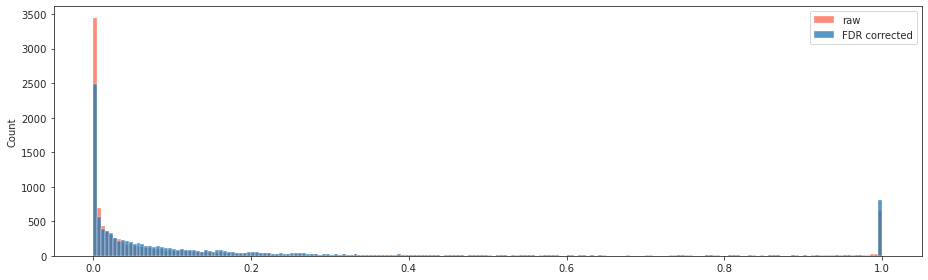

In [9]:
fig, ax = create_figure(1, 1, figsize=(13, 4))

sns.histplot(pvals.ravel(), bins=np.linspace(0, 1, 201), color='tomato', label='raw')
sns.histplot(pvals_fdr.ravel(), bins=np.linspace(0, 1, 201), color='C0', label='FDR corrected')
plt.legend()
plt.show()

In [10]:
(pvals >= 0.05).sum() / ((pvals < 0.05).sum() + (pvals >= 0.05).sum())

0.40019175455417066

In [11]:
(rej == 0).sum() / ((rej == 0).sum() + (rej == 1).sum())

0.4987535953978907

for rej == 0, we fail to reject the null hypothesis (H_0: X_n <= 0.003), therefore we have to zero-out those values.  Therefore, roughly speaking pi[rej == 0] = 0 .  Also, FDR increased the number of nodes that I have to zero out now (before it was 40% of membership values but with FDR it is now roughly 50% of membership values)

H_0 is something I really want and hope to reject.  For instance, in the prune task, I say that $H_0 = \bar{X}_n \leq 0.003$, because I want to reject this with confidence and keep the membership value (leave it alone).  When I fail to reject this, I have to zero out that value.  That's why pi[rej == 0] = 0.

### TODO: find out if you should do FDR for individual animals separately

In [20]:
self = gr_ca
pi = avg(pi, 2, se.ndim - 2)

tvals = (pi - mu) / se
pvals = np.zeros(pi.shape)
rejected = np.zeros(pi.shape)

anim_n_runs = self.get_anim_num_runs()
for i in range(len(pi)):
    anim_key = self.mice.get_key(i + 1)
    dof = anim_n_runs[anim_key] - 1
    p = sp_stats.t.cdf(tvals[i], dof)
    p = 1 - p
    nonan = np.isfinite(p)
    rejected[i][nonan], pvals[i][nonan], *_ = multipletests(
        pvals=p[nonan],
        alpha=alpha,
        method='fdr_bh',
        is_sorted=False,
        returnsorted=False,
    )

In [22]:
(rejected == 0).sum() / ((rejected == 0).sum() + (rejected == 1).sum())

0.5131578947368421

In [14]:
pi.shape, rej.shape

((10, 7, 152), (10, 7, 152))

In [20]:
pi_prune = gr_ca.run_pi.copy()

In [30]:
vote = np.expand_dims(np.expand_dims(np.expand_dims(
    rej, 1), 1), 1)
vote = np.repeat(vote, 3, axis=1)
vote = np.repeat(vote, 4, axis=2)
vote = np.repeat(vote, 300, axis=3)
vote.shape

(10, 3, 4, 300, 7, 152)

In [50]:
pi_prune[vote == 0] = 0.0
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)

In [51]:
pi_prune.shape

(10, 3, 4, 300, 7, 152)

In [52]:
rej[4, 2, 14]

0.0

In [53]:
avg(pi_prune, 2, 1)[4,:,14]

array([1., 0., 0., 0., 0., 0., 0.])

In [54]:
avg(gr_ca.run_pi, 2, 1)[4,:,14]

array([0.55323151, 0.00475567, 0.08645293, 0.00559171, 0.3179678 ,
       0.01180767, 0.0201927 ])

In [57]:
pvals_fdr[4, :, 14]

array([0.01731641, 0.30718351, 0.07612811, 0.16342734, 0.06771205,
       0.160749  , 0.08332742])

In [ ]:
pvals[4, :, 14]

In [18]:
ids = np.unravel_index(np.nanargmin(pvals), pvals.shape)
ids

(0, 2, 6)

In [21]:
pvals[ids], pvals_fdr[ids], pi[ids], rej[ids]

(0.0, 0.0, 0.9609009720359751, 1.0)

In [22]:
ids = np.unravel_index(np.nanargmax(pvals), pvals.shape)
ids

(0, 1, 0)

In [23]:
pvals[ids], pvals_fdr[ids], pi[ids], rej[ids]

(1.0, 1.0, 0.002006992877052643, 0.0)

In [28]:
diff = np.logical_and(pvals < 0.05, rej == 0)
diff = list(zip(*np.where(diff)))
len(diff)

1028

In [32]:
pi[diff[125]], pvals[diff[125]], pvals_fdr[diff[125]], rej[diff[125]]

(0.01865116476359707, 0.025669917246298524, 0.05089094029250971, 0.0)

In [33]:
pi[diff[561]], pvals[diff[561]], pvals_fdr[diff[561]], rej[diff[561]]

(0.04571148435422088, 0.02746268652238959, 0.05349083221353604, 0.0)

In [52]:
def ttest(
        self,
        se: np.ndarray,
        pi: np.ndarray = None,
        mu: float = 0.003,
        alpha: float = 0.05,
        fdr: bool = True, ):

    pi = pi if pi is not None else self.run_pi
    pi = avg(pi, 2, se.ndim - 2)
    assert pi.shape == se.shape

    tvals = (pi - mu) / se
    pvals = np.zeros(se.shape)
    if se.ndim == 3:
        anim_n_runs = self.get_anim_num_runs()
        for i in range(len(se)):
            anim_key = self.mice.get_key(i + 1)
            dof = anim_n_runs[anim_key] - 1
            p = sp_stats.t.cdf(tvals[i], dof)
            pvals[i] = 1 - p
    else:
        raise NotImplementedError

    if fdr:
        nonan = np.isfinite(pvals)
        rej = np_nans(pvals.shape)
        pvals_fdr = np_nans(pvals.shape)
        rej[nonan], pvals_fdr[nonan], *_ = multipletests(
            pvals=pvals[nonan],
            alpha=alpha,
            method='fdr_bh',
            is_sorted=False,
            returnsorted=False,
        )
        return rej, pvals_fdr, pvals, tvals
    else:
        return pvals < alpha

In [53]:
alpha = 0.05
mu = 0.003

rej, pvals_fdr, pvals, tvals = ttest(
    gr_ca,
    se=se,
    mu=mu,
    alpha=alpha,
    fdr=True,
)

<AxesSubplot:ylabel='Count'>

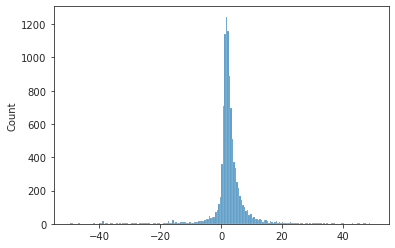

In [56]:
sns.histplot(tvals[np.isfinite(tvals)], bins=np.linspace(-50, 50, 201))

In [57]:
xxx = sp_stats.t.cdf(tvals, 11)

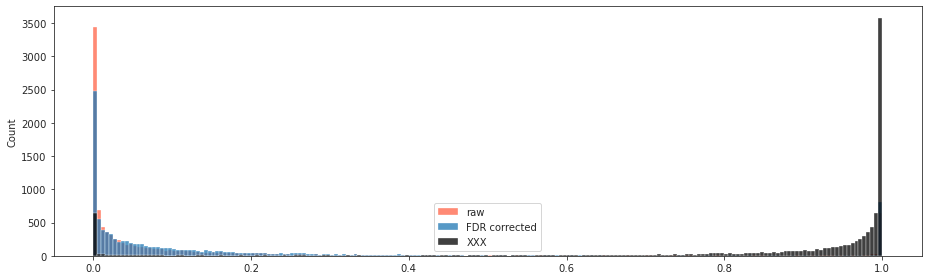

In [59]:
fig, ax = create_figure(1, 1, figsize=(13, 4))

sns.histplot(pvals.ravel(), bins=np.linspace(0, 1, 201), color='tomato', label='raw')
sns.histplot(pvals_fdr.ravel(), bins=np.linspace(0, 1, 201), color='C0', label='FDR corrected')
sns.histplot(xxx.ravel(), bins=np.linspace(0, 1, 201), color='k', label='XXX')
plt.legend()
plt.show()

In [62]:
ids = np.unravel_index(np.nanargmax(xxx), xxx.shape)
ids

(0, 2, 6)

In [63]:
pi[ids]

0.9609009720359751

In [64]:
ids = np.unravel_index(np.nanargmin(xxx), xxx.shape)
ids

(8, 1, 79)

In [65]:
pi[ids]

0.0020555389866820117

In [68]:
np.unravel_index(np.nanargmin(gr_ca.run_pi), gr_ca.run_pi.shape)

(3, 0, 0, 73, 0, 53)

In [69]:
gr_ca.run_pi[3, 0, 0, 73, :, 53]

memmap([0.00191758, 0.9884945 , 0.00191758, 0.00191758, 0.00191758,
        0.00191758, 0.00191758])

In [41]:
sp_stats.t.ppf(0.025, 9), sp_stats.t.ppf(0.975, 9)

(-2.262157162740992, 2.2621571627409915)

In [42]:
t = sp_stats.t.ppf(0.975, 9)
np.round(t, 10)

2.2621571627

In [43]:
c = sp_stats.t.cdf(t, 9)
np.round(c, 10)

0.975

In [291]:
list(zip(*np.where(rej == 0)))[1]

(0, 0, 1)

In [292]:
pi[0,0,1]

0.04372370580411694

In [265]:
reject_h0.sum() / np.prod(reject_h0.shape), (~reject_h0).sum() / np.prod(reject_h0.shape)

(0.58796992481203, 0.4120300751879699)

In [278]:
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.multitest import multipletests

In [281]:
rejected_corrected = np_nans(pvals.shape)
pvals_corrected = np_nans(pvals.shape)
rejected_corrected[np.isfinite(pvals)], pvals_corrected[np.isfinite(pvals)], *_ = multipletests(
    pvals[np.isfinite(pvals)], alpha=alpha, method='fdr_bh')

In [282]:
rejected_corrected.shape, pvals_corrected.shape

((10, 7, 152), (10, 7, 152))

<AxesSubplot:ylabel='Count'>

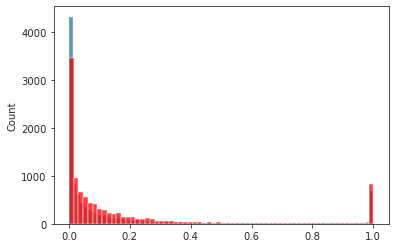

In [264]:
sns.histplot(pvals[np.isfinite(pvals)])
sns.histplot(pvals_corrected[np.isfinite(pvals)], color='r')

In [254]:
nans = list(zip(*np.where(np.isnan(pvals))))

In [255]:
nans[52]

(3, 3, 129)

In [256]:
pvals[3, 3, 129]

nan

In [257]:
pvals_corrected[3, 3, 129]

nan

In [260]:
(rejected == 1).sum()

5228

In [271]:
diff = np.logical_and(rejected_corrected == 0, reject_h0 == 1)
diff.sum()

1028

In [272]:
false_positives = list(zip(*np.where(diff)))

In [273]:
false_positives[0]

(0, 0, 0)

In [276]:
pi[false_positives[0]], pvals[false_positives[0]]

(0.1146436855008565, 0.048609696918250234)

In [277]:
pi[false_positives[0]], pvals_corrected[false_positives[0]]

(0.1146436855008565, 0.0815635680272442)

In [203]:
tvals = (pi - mu) / se
pvals = 1 - sp_stats.t.cdf(tvals, 11)
reject_h0 = pvals < alpha

<AxesSubplot:ylabel='Count'>

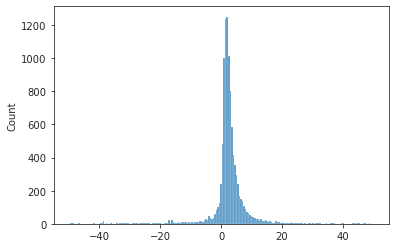

In [204]:
sns.histplot(tvals.ravel(), bins=np.linspace(-50, 50, 200))

<AxesSubplot:ylabel='Count'>

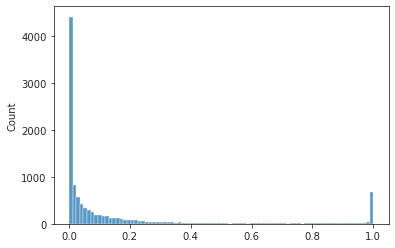

In [209]:
sns.histplot(pvals.ravel())

In [205]:
output = gr_ca.cast_votes(se)

In [206]:
output['votes'].sum()

6509

In [208]:
reject_h0.sum()

6298

In [192]:
np.unravel_index(np.nanargmax(tvals), tvals.shape)

(9, 2, 79)

In [199]:
pi[9, 2, 79], tvals[9, 2, 79], pvals[9, 2, 79]

(0.9762420555990354, 341.56247575206766, 0.0)

In [200]:
np.unravel_index(np.nanargmin(tvals), tvals.shape)

(8, 1, 79)

In [201]:
pi[8, 1, 79], tvals[8, 1, 79], pvals[8, 1, 79]

(0.0020555389866820117, -372798185.58709013, 1.0)

In [39]:
sp_stats.t.cdf(-2, 11)

0.03540197753401726

In [22]:
reject_h0.sum() / np.prod(reject_h0.shape)

0.07171052631578947

In [23]:
reject_h0.sum()

763

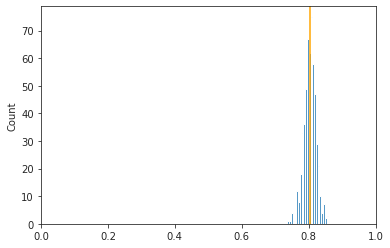

In [157]:
ids = (8, 2, 79)
x = boot.copy()
for i in range(3):
    x = np.take(x, ids[i], axis=1)

sns.histplot(x)
plt.axvline(pi[ids], color='orange')
plt.xlim(0, 1)
plt.show()

In [93]:
mu

0.003

In [94]:
se = bn.nanstd(boot - mu, 0, ddof=1)

In [95]:
pi[ids], se[ids]

(0.031121389383879303, 0.02009893535758423)

In [96]:
(pi[ids] - 0.003) / se[ids]

1.3991482077814554

In [97]:
sp_stats.t.cdf((pi[ids] - 0.003) / se[ids], 11)

0.9053354663033654

In [170]:
ci = 0.95
t95 = sp_stats.t.ppf(ci, 11)
t95

1.7958848187036691

In [172]:
ids2zero = (8, 2, 22)
pi[ids2zero], pi[ids2zero] - t95 * se[ids2zero] , pi[ids2zero] + t95 * se[ids2zero]

(0.031121389383879303, -0.0049739834969126165, 0.06721676226467121)

In [173]:
ids2leave = (8, 2, 79)
pi[ids2leave], pi[ids2leave] - t95 * se[ids2leave] , pi[ids2leave] + t95 * se[ids2leave]

(0.8038046724089252, 0.77092495233124, 0.8366843924866103)

In [174]:
mu

0.003

In [175]:
t = (pi[ids2zero] - mu) / se[ids2zero]
t

1.3991482077814554

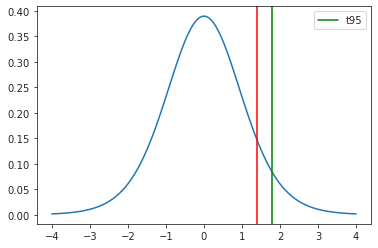

In [179]:
x = np.linspace(-4, 4, 100)
y = sp_stats.t.pdf(x, 11)

plt.plot(x, y)
plt.axvline(t, color='r')
plt.axvline(t95, color='g', label='t95')
plt.legend()
plt.show()

In [180]:
sp_stats.t.cdf(t, 11)

0.9053354663033654

<AxesSubplot:ylabel='Count'>

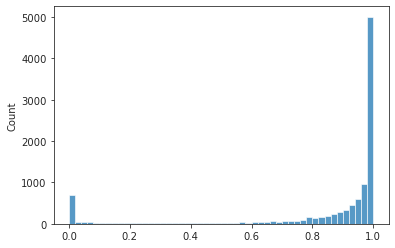

In [24]:
sns.histplot(pvals.ravel(), bins=np.linspace(0, 1, 51))

In [5]:
ovp_scores = gr_ca.ovp_score()
list(ovp_scores)

['se_oc', 'se_node', 'score_oc', 'score_node', 'num_comm']

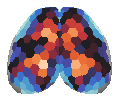

In [6]:
xxx = avg(ovp_scores['num_comm'], 1)
_ = gr_ca.show(xxx, vmin=np.nanmin(xxx), vmax=np.nanmax(xxx), cmap='icefire', add_disjoint=False)

In [7]:
np.argmax(xxx)

52

In [8]:
aaa = ovp_scores['num_comm'][..., 52]
avg(aaa, 0, 0)

2.06968212266134

<AxesSubplot:ylabel='Count'>

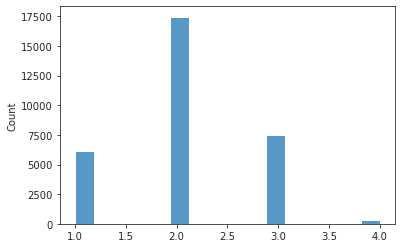

In [9]:
sns.histplot(aaa[np.isfinite(aaa)])

In [10]:
three_freq = np_nans(len(gr_ca.n2l))
ovp_freq = np_nans(len(gr_ca.n2l))
for nn in gr_ca.n2l:
    x = ovp_scores['num_comm'][..., nn]
    counts = collections.Counter(x[np.isfinite(x)])
    counts = {i: counts.get(i, 0) for i in range(1, gr_ca.num_k + 1)}
    counts = {i: x / sum(counts.values()) for i, x in counts.items()}

    three_freq[nn] = counts.get(3)
    ovp_freq[nn] = 1 - counts.get(1)

[<matplotlib.lines.Line2D object at 0x7f88eada34f0>]

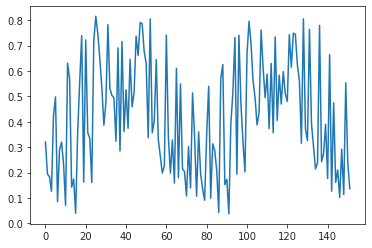

In [11]:
plt.plot(ovp_freq)

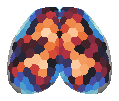

In [12]:
_ = gr_ca.show(ovp_freq, vmin=np.nanmin(ovp_freq), vmax=np.nanmax(ovp_freq), cmap='icefire', add_disjoint=False)

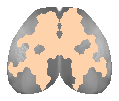

In [13]:
xxx = ovp_freq.copy()
xxx[xxx > 0.5] = 1
xxx[xxx <= 0.5] = 0
_ = gr_ca.show(xxx, vmin=np.nanmin(ovp_freq), vmax=np.nanmax(ovp_freq), cmap='icefire', add_disjoint=False)

[<matplotlib.lines.Line2D object at 0x7f88ef645be0>]

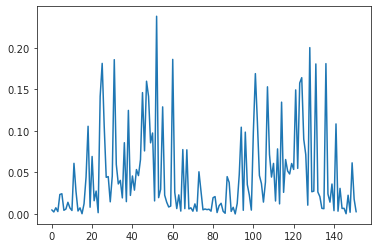

In [14]:
plt.plot(three_freq)

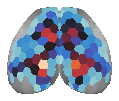

In [15]:
_ = gr_ca.show(three_freq, vmin=np.nanmin(three_freq), vmax=np.nanmax(three_freq), cmap='icefire', add_disjoint=False)

In [16]:
boot = bootstrap(
    x=ovp_scores['num_comm'],
    n_resamples=int(5e2),
)
boot.shape

(500, 10, 3, 4, 300, 152)

In [17]:
three_freq_b = np_nans((len(boot), len(gr_ca.n2l)))
ovp_freq_b = np_nans((len(boot), len(gr_ca.n2l)))
for ii in tqdm(range(len(boot))):
    for nn in gr_ca.n2l:
        if nn not in [52]:
            continue
        x = boot[ii, ..., nn]
        counts = collections.Counter(x[np.isfinite(x)])
        counts = {i: counts.get(i, 0) for i in range(1, gr_ca.num_k + 1)}
        counts = {i: x / sum(counts.values()) for i, x in counts.items()}

        three_freq_b[ii, nn] = counts.get(3)
        ovp_freq_b[ii, nn] = 1 - counts.get(1)

  0%|          | 0/500 [00:00<?, ?it/s]

<matplotlib.lines.Line2D object at 0x7f88ead247c0>

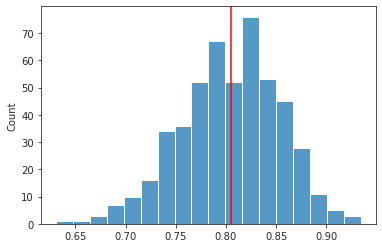

In [18]:
sns.histplot(ovp_freq_b[:, 52])
plt.axvline(ovp_freq[52], color='r')

In [6]:
ovp_scores['score_oc']

array([68.68599529, 52.34769214, 44.91072923, 76.54723213, 71.39646973,
       65.06401916, 59.53672136])

In [9]:
ovp_scores['score_node']

array([55.66474015, 39.1031925 ,  5.13313711,  0.09893024,  0.        ,
        0.        ,  0.        ])

In [10]:
ovp_scores['se_node']

array([0.62572314, 0.56395754, 0.19149329, 0.01385539, 0.        ,
       0.        , 0.        ])

In [14]:
tval = sp_stats.t.ppf(0.95, 9)

In [15]:
lower = ovp_scores['score_node'] - ovp_scores['se_node'] * tval
higher = ovp_scores['score_node'] + ovp_scores['se_node'] * tval

In [16]:
lower

array([54.51771897, 38.06939464,  4.78210828,  0.07353175,  0.        ,
        0.        ,  0.        ])

In [17]:
higher

array([56.81176133, 40.13699036,  5.48416594,  0.12432873,  0.        ,
        0.        ,  0.        ])

In [18]:
lower = ovp_scores['score_oc'] - ovp_scores['se_oc'] * tval
higher = ovp_scores['score_oc'] + ovp_scores['se_oc'] * tval

In [19]:
lower

array([65.66506551, 48.25236158, 40.85795484, 73.64984987, 67.83082765,
       61.87271689, 55.10502109])

In [20]:
higher

array([71.70692507, 56.4430227 , 48.96350362, 79.4446144 , 74.96211181,
       68.25532144, 63.96842164])

In [21]:
ovp_scores['score_oc'].mean()

62.641265578223205

In [24]:
ovp_scores['score_oc'].mean()

75.20510234076313

In [32]:
ovp_scores['score_oc'].mean()

47.031728395977865

In [25]:
ovp_scores['score_oc']

array([70.43525264, 65.93159901, 61.4748051 , 80.79816291, 71.11847923,
       81.25766392, 76.63490482, 70.51315847, 70.4863544 , 86.22560708,
       77.34828857, 79.50369849, 84.88537088, 76.25808726])

In [26]:
ovp_scores['score_node']

array([42.66901424, 46.81690827, 10.1802425 ,  0.33383499,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [33]:
ovp_scores['score_node']

array([6.92871281e+01, 2.91490176e+01, 1.55626321e+00, 7.59116145e-03])

In [5]:
pi = gr_ca.run_pi.copy()

In [6]:
x = pi > 0.2
num_comm = x.sum(-2, keepdims=True)

In [7]:
num_comm = num_comm.squeeze().astype(float)
num_comm[num_comm == 0] = np.nan
num_comm.shape

(10, 3, 4, 300, 152)

In [8]:
xxx = avg(num_comm, 1)

[<matplotlib.lines.Line2D object at 0x7f254b80ac10>]

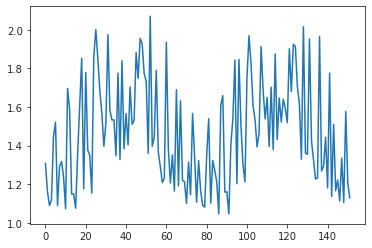

In [9]:
plt.plot(xxx)

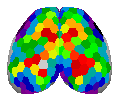

In [10]:
_ = gr_ca.show(xxx, vmin=np.nanmin(xxx), vmax=np.nanmax(xxx), cmap='nipy_spectral', add_disjoint=False)

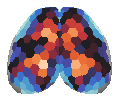

In [11]:
_ = gr_ca.show(xxx, vmin=np.nanmin(xxx), vmax=np.nanmax(xxx), cmap='icefire', add_disjoint=False)

In [20]:
pi = gr_ca.run_pi.copy()
pi.shape

(10, 3, 4, 300, 7, 152)

In [21]:
thres = 0.2

In [22]:
x = pi > thres
num_comm = x.sum(-2, keepdims=True)

In [23]:
score_oc = ((num_comm > 1) * x).sum(-1) / x.sum(-1) * 100

In [24]:
num_comm.shape, score_oc.shape

((10, 3, 4, 300, 1, 152), (10, 3, 4, 300, 7))

In [25]:
boot = bootstrap(
    x=score_oc,
    n_resamples=int(1e3),
    dims=4,
)
boot.shape

(1000, 10, 3, 4, 300, 7)

In [26]:
boot = avg(boot, 1, 1)
boot.shape

(1000, 7)

In [27]:
se_oc = bn.nanstd(boot, 0, ddof=1)
se_oc

array([1.647978  , 2.23408525, 2.21087   , 1.58058034, 1.94512952,
       1.74091962, 2.41758169])

In [28]:
score_oc = avg(score_oc, 1)

In [29]:
score_oc

array([68.68599529, 52.34769214, 44.91072923, 76.54723213, 71.39646973,
       65.06401916, 59.53672136])

In [33]:
num_comm = num_comm.squeeze()
num_comm.shape

(10, 3, 4, 300, 152)

In [34]:
bins = np.arange(0, pi.shape[-2] + 1)
bins

array([0, 1, 2, 3, 4, 5, 6, 7])

In [35]:
pi.shape[:4]

(10, 3, 4, 300)

In [36]:
dims = pi.ndim - 2
dims

4

(10, 3, 4, 300)

In [46]:
for ids in itertools.product(*(range(i) for i in pi.shape[:dims])):
    ids

In [47]:
ids

(9, 2, 3, 299)